# Project description 

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning, and you are asked to evaluate that possibility.

- **Task 1:** Find customers who are similar to a given customer. This will help the company's agents with marketing.
- **Task 2:** Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- **Task 3:** Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- **Task 4:** Protect clients' personal data without breaking the model from the previous task.

It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called *data masking*, or *data obfuscation*. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

**Data description:**
- **Features:** insured person's gender, age, salary, and number of family members.
- **Target:** number of insurance benefits received by an insured person over the last five years.

# Data preparation

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression

from scipy.spatial import distance

In [2]:
try:
    insurance_df = pd.read_csv('datasets/insurance_us.csv')
except:
    print('The file path is incorrect!')

In [3]:
insurance_df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
# shape of the dataframe 
insurance_df.shape

(5000, 5)

In [5]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# fix the columns' names
insurance_df.columns = ['gender', 'age', 'salary', 'family_members', 'insurance_benefits']

In [7]:
# convert all DataFrame columns to the int64 dtype
insurance_df[['gender', 'age', 'family_members', 'insurance_benefits']] = insurance_df[['gender', 'age', 'family_members', 'insurance_benefits']].astype('int8')
insurance_df['salary'] = insurance_df['salary'].astype('int32')

In [8]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int8 
 1   age                 5000 non-null   int8 
 2   salary              5000 non-null   int32
 3   family_members      5000 non-null   int8 
 4   insurance_benefits  5000 non-null   int8 
dtypes: int32(1), int8(4)
memory usage: 39.2 KB


In [9]:
# missed values in columns
insurance_df.isna().sum()

gender                0
age                   0
salary                0
family_members        0
insurance_benefits    0
dtype: int64

In [10]:
# duplicates in the dataframe
insurance_df.duplicated().sum()

153

In [11]:
# Let's look closer on those duplicates
insurance_df[insurance_df.duplicated(keep=False)].sort_values(['gender', 'age', 'salary']).head(10)

,gender,age,salary,family_members,insurance_benefits
1751,0,19,38600,0,0
3268,0,19,38600,0,0
851,0,19,51700,0,0
2853,0,19,51700,0,0
688,0,20,35800,0,0
785,0,20,35800,0,0
1313,0,20,36800,0,0
2654,0,20,36800,0,0
3918,0,20,41500,2,0
4125,0,20,41500,2,0


**Intermediate result:** the memory consumption has been decreased 5 fold. The columns' names have been corrected. There are no missed values in the data frame. However, there are some duplicates 153 duplicated rows. It is hard to say, whether it is an issue, or just clients with similar parameters. Let's leave those duplicates as they are.

# EDA

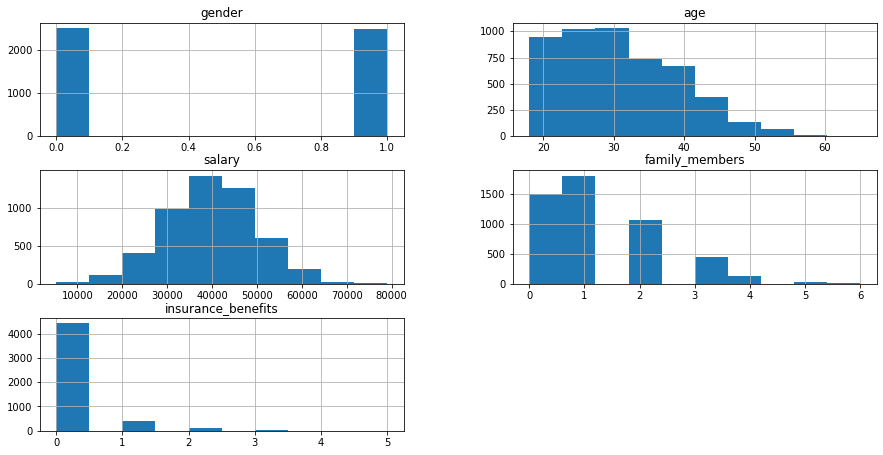

In [12]:
insurance_df.hist(figsize=(15, 7.5))
plt.show()

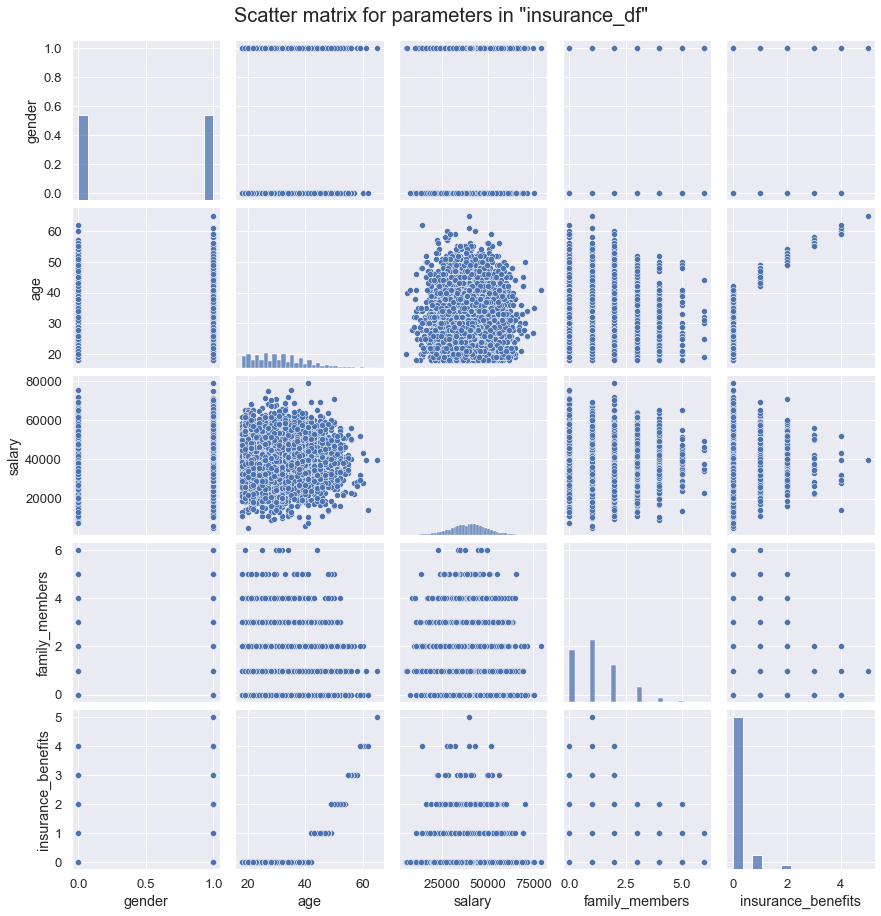

In [13]:
sns.set(font_scale=1.2)
sns.pairplot(insurance_df)
plt.suptitle('Scatter matrix for parameters in "insurance_df"', fontsize=20, y=1.02)
plt.show()

In [14]:
# Searching for multicollinearity
insurance_df.corr().round(2).style.background_gradient()

,gender,age,salary,family_members,insurance_benefits
gender,1.000000,0.000000,0.010000,-0.010000,0.010000
age,0.000000,1.000000,-0.020000,-0.010000,0.650000
salary,0.010000,-0.020000,1.000000,-0.030000,-0.010000
family_members,-0.010000,-0.010000,-0.030000,1.000000,-0.040000
insurance_benefits,0.010000,0.650000,-0.010000,-0.040000,1.000000


**Intermediate conclusion:**
Data looks fine - there are only 2 genders, reasonable amount of family members, reasonable values for age, salary and so on. Finally, we can see that there is a pretty strong positive correlation of 0.65 between `age` and `insurance_benefits`, which is logical. 

# Task 1. Similar Customers

Develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the scaler


- Distance Metrics
  - Euclidean
  - Manhattan

In [15]:
# Let's split the data into features and target
features = insurance_df.drop('insurance_benefits', axis=1)
target = insurance_df['insurance_benefits']

In [16]:
def get_knn(df, n, k, metric):
    """
    Returns a df with k nearest neighbors for the specified row in a dataframe (df.iloc[n] vector)

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    
    """
    # initializing NearestNeighbors class with a predefined metric
    nbrs = NearestNeighbors(metric=metric)
    
    # uploading the df into the class
    nbrs.fit(df)
    
    # finding k nearest vectors and their indexes to the vector n in the df
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n]], k)
    
    # making a dataframe from indices and distances
    nbrs_df = pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    
    # making a resulting df by adding this data to the main df according to the number of k vectors
    result_df = pd.concat([df.iloc[nbrs_df.index], nbrs_df], axis=1)
    return result_df

## Similar customers without scaling

### Euclidean metric

In [17]:
get_knn(features, 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1,41,49600,1,0.000000
2022,1,41,49600,0,1.000000
1225,0,42,49600,0,1.732051
4031,1,44,49600,2,3.162278
3424,0,38,49600,0,3.316625
815,1,37,49600,2,4.123106
4661,0,45,49600,0,4.242641
2125,0,37,49600,2,4.242641
2349,1,46,49600,2,5.099020
3900,1,36,49600,0,5.099020


### Manhattan metric

In [18]:
get_knn(features, 0, 10, 'manhattan')

,gender,age,salary,family_members,distance
0,1,41,49600,1,0.0
2022,1,41,49600,0,1.0
1225,0,42,49600,0,3.0
4031,1,44,49600,2,4.0
815,1,37,49600,2,5.0
3424,0,38,49600,0,5.0
2125,0,37,49600,2,6.0
3900,1,36,49600,0,6.0
2349,1,46,49600,2,6.0
4661,0,45,49600,0,6.0


## Similar customers with scaling

In [34]:
# scaling the data
features_scaled = MaxAbsScaler().fit_transform(features)
features_scaled = pd.DataFrame(features_scaled)

# transforming the data back to a df look
features_scaled.columns = ['gender', 'age', 'salary', 'family_members']
features_scaled.head()

,gender,age,salary,family_members
0,1.0,0.630769,0.627848,0.166667
1,0.0,0.707692,0.481013,0.166667
2,0.0,0.446154,0.265823,0.000000
3,0.0,0.323077,0.527848,0.333333
4,1.0,0.430769,0.330380,0.000000


### Euclidean metric

In [20]:
get_knn(features_scaled, 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.017754
4869,1.0,0.646154,0.637975,0.166667,0.018418
3275,1.0,0.646154,0.651899,0.166667,0.028550
1567,1.0,0.615385,0.602532,0.166667,0.029624
2103,1.0,0.630769,0.596203,0.166667,0.031646
3365,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.031693
3636,1.0,0.615385,0.600000,0.166667,0.031815


### Manhattan metric

In [21]:
get_knn(features_scaled, 0, 10, 'manhattan')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.024245
4869,1.0,0.646154,0.637975,0.166667,0.025511
3365,1.0,0.630769,0.596203,0.166667,0.031646
2103,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.038364
4305,1.0,0.630769,0.588608,0.166667,0.039241
3275,1.0,0.646154,0.651899,0.166667,0.039435
1567,1.0,0.615385,0.602532,0.166667,0.040701


## Conclusion

In this chapter, we have performed a function to calculate the distance between vectors. We have applied this function 2 times:
1. Without data scaling.
2. With data scaling.

In the first case, we can see that for the Euclidean distance, the distance values between different vectors are pretty high ( float values from 1 to 5). In the case of Manhattan distance, the distance also significantly differs between various vectors (int numbers from 1 to 6).

However, after scaling the data the results for both Euclidean and Manhattan distances differ significantly from the previous case. The distances between vectors have decreased by 3 orders of magnitude for both distances and now the Manhattan distance shows float values as well.

As we can see, data scaling significantly affects the knn algorithm.

# Task 2: Predict whether a new customer is likely to receive an insurance benefit.

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, we will evaluate whether the KNN classification approach can do better than a dummy model.

We will:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influence the evaluation metric, and whether scaling the data makes any difference. 

- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

We need to split the whole data in the 70:30 proportion for the training / testing parts.

## Without scaling

Only 11.28 % of people have insurance benefits


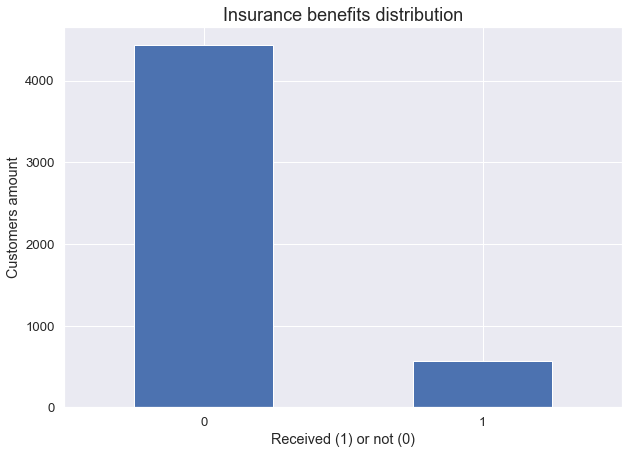

In [22]:
# Let's split the data into features and target
features = insurance_df.drop('insurance_benefits', axis=1)

#make the new target values:
insurance_df['insurance_benefits_received'] = insurance_df['insurance_benefits'].apply(lambda x: 1 if x>0 else 0)

# make the tarket from the new columns
target = insurance_df['insurance_benefits_received']

# let's look at the new target values
print(f'Only {round((564/len(insurance_df))*100, 2)} % of people have insurance benefits')
insurance_df['insurance_benefits_received'].value_counts().plot(kind='bar', rot=0, figsize=(10, 7))
plt.title('Insurance benefits distribution', fontsize=18)
plt.ylabel('Customers amount')
plt.xlabel('Received (1) or not (0)')
plt.show()

> We can see, that the 'insurance_benefits_received' values are highly imbalanced. Most of the people do not receive any insurance benefits.


F1 score of the best model = 0.652
k neighbors of the best model = 1


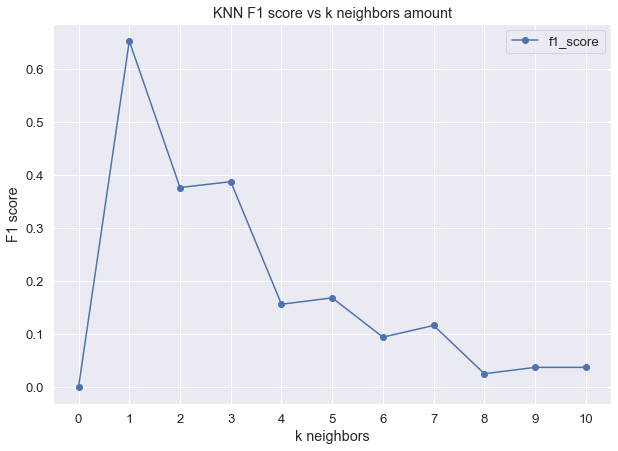

In [23]:
random = RandomState(42)
# define the kNN range
k_neighbors = list(range(1, 11))

# a function to test a KNN-model performance based on a k-value
def knn_model(features, target, k_neighbors):
    # split the data
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    # initialize the "best" parameters
    best_model = None
    best_score = 0
    best_neigbors = 0
    
    # create a result dataframe
    result_df = pd.DataFrame({'f1_score': [0]})
    
    # go through the kNN range and check the model's  performance
    for i in k_neighbors:
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(features_train, target_train)
        score = f1_score(target_test, model.predict(features_test))
        
        # write down the 
        result_df.loc[i] = (round(score, 3))

        if score > best_score:
            best_model = model
            best_score = score
            best_neigbors = i

    print('')
    print(f'F1 score of the best model = {round(best_score, 3)}')
    print(f'k neighbors of the best model = {best_neigbors}')
    
    result_df.plot(kind='line', figsize=(10, 7), marker='o', title='KNN F1 score vs k neighbors amount')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.xlabel('k neighbors')
    plt.ylabel('F1 score')
    plt.show()

knn_model(features, target, k_neighbors)

In [24]:
def dummy_clf(features, target):
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)
    dummy_clf = DummyClassifier(strategy="uniform")
    dummy_clf.fit(features_train, target_train)
    predictions = dummy_clf.predict(features_test)
    score = f1_score(target_test, predictions)
    print(f"Dummy classifier's F1 score: {round(score, 3)}")

dummy_clf(features, target)

Dummy classifier's F1 score: 0.192


## With scaling


F1 score of the best model = 0.939
k neighbors of the best model = 3


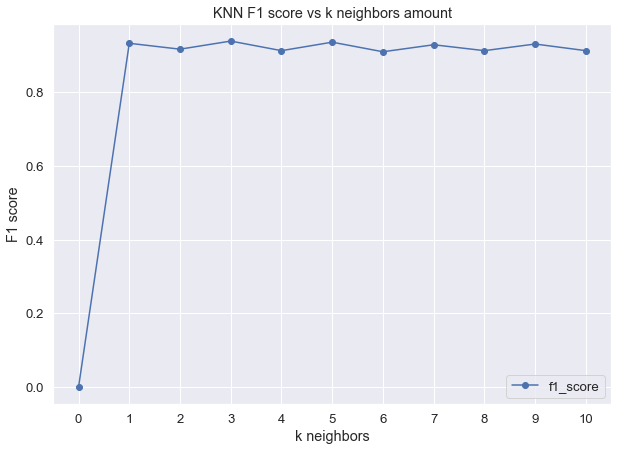

In [25]:
knn_model(features_scaled, target, k_neighbors)

In [26]:
dummy_clf(features_scaled, target)

Dummy classifier's F1 score: 0.198


## Conclusion 
* **For the unscaled data:**
 - The best KNN model has 1 nearest neighbor and the `F1 score = 0.652`. The F1 score was rapidly decreasing with increased amount of k.
 - The dummy model achieved the F1 score = 0.186
* **For the scaled data:**
 - The best KNN model has 3 nearest neighbors and the `F1 score = 0.939`. The F1 score was more or less stable in the whole k range.
 - The dummy model achieved the F1 score = 0.174
 
This clearly shows the importance of data scaling for the KNN classification technique.

# Task 3: Regression prediction of the client's insurance benefits amount.

## Without scaling

In [27]:
# set the target as the `insurance_benefits` column
target = insurance_df['insurance_benefits']

def linear_reg(features, target):
    #splitting the data
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(target_test, predictions)
    
    print(f"Linear regression's RMSE = {round(rmse, 3)}")

linear_reg(features, target)

Linear regression's RMSE = 0.132


## With scaling

In [28]:
# let's use the function we've created previously
linear_reg(features_scaled, target)

Linear regression's RMSE = 0.132


## Conclusion

Data scaling had no effect on the Linear Regression model and both models got identical RMSE value = 0.132

# Task 4: Data obfuscation

In [29]:
# creating a numpy matrix from the features
X = features.to_numpy()

# set up the random matrix generator with seed
rng = np.random.default_rng(seed=42)
# generate random matrix
P = rng.random(size=(X.shape[1], X.shape[1]))

In [30]:
print('='*20, 'Randomly generated matrix', '='*20)
display(P)

print('='*20, 'Inverted randomly generated matrix', '='*20)
display(np.linalg.inv(P))

==================== Randomly generated matrix ====================


array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

==================== Inverted randomly generated matrix ====================


array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [31]:
# display the first 5 rows of the original matrix
print('='*30, 'Original data', '='*30)
display(X[:5])

# creating an obfuscated matrix
X_t = X @ P

# display the first 5 rows of the obfuscated matrix
print('='*30, 'Obfuscated data', '='*30)
display(X_t[:5])

# recovered data matrix
X_r = (X_t @ np.linalg.inv(P)).astype('int')

# display the first 5 rows of the recovered data
print('='*30, 'Recovered data', '='*30)
display(X_r[:5])

============================== Original data ==============================


array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       [    0,    21, 41700,     2],
       [    1,    28, 26100,     0]], dtype=int32)

============================== Obfuscated data ==============================


array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       [ 5345.60393712, 18803.22720286, 15479.14837264, 38663.06186284],
       [ 3347.17673462, 11782.82928336,  9699.99894205, 24211.27337753]])

============================== Recovered data ==============================


array([[    1,    41, 49599,     1],
       [    0,    45, 38000,     1],
       [    0,    28, 21000,     0],
       [    0,    20, 41700,     2],
       [    1,    27, 26099,     0]])

## Testing linear regression with data obfuscation

In [32]:
# convert obfuscated features matrix back to a dataframe format
features_obf = pd.DataFrame(X_t, columns=['gender', 'age', 'income', 'family_members'])
features_obf.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [33]:
# let's use the function we've created previously
linear_reg(features_obf, target)

Linear regression's RMSE = 0.132


## Conclusion

Data obfuscation procedure has been successfully performed. We could observe that obfuscation do not influence Linear Regression.

# Final conclusion

- The size of the dataset has been decreased 5-fold by changing the dtype of columns. The columns' names have been corrected.
- No strange values haven't been detected in the dataset. Data looks fine - there are only 2 genders, a reasonable amount of family members, reasonable values for age, salary, and so on. Finally, we have found a pretty strong positive correlation of 0.65 between age and insurance_benefits, which is logical.
- We have performed a function to calculate the distance between vectors. We found a high impact of data scaling on both Manhattan and Euclidean metrics.
- A big influence on the F1 score of KNN models has been demonstrated in a prediction of whether the client will receive any insurance benefits.
- Our results have shown that data scaling had no effect on the Linear Regression model and both models got identical RMSE value = 0.132 after predicting clients' insurance benefits amount.
- Finally, we have performed data obfuscation and proved that it has no influence on the Linear Regression's RMSE metric.